## DATA PREPROCESSING AND FEATURE ENGINEERING

## Data Preprocessing and Feature Engineering

The dataset was first cleaned to handle missing values and remove unnecessary columns. Categorical features such as `city` and  `country` were converted into numerical form using one-hot encoding.

From the `date` column, new features for day, month, and year were created, and the `hour` feature was transformed into sine and cosine values to capture its cyclical nature. A new feature, cloud thickness, was calculated from cloud top and base heights to represent atmospheric conditions.

Finally, all numeric features were scaled to ensure consistent ranges across variables. These preprocessing and feature engineering steps were applied to both the training and test sets, preparing the data for the machine learning and deep learning models.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
import random





In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [3]:
def load_data(train_path, test_path):
    """Load training and test datasets."""
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test


In [4]:
train, test = load_data("train.csv", "test.csv")

In [5]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (8071, 80)
Test shape: (2783, 79)


,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,...,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-08,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.537600
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,...,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 80 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

In [7]:
# drop id and site_id column since it does not help with prediction
train.drop(columns=['id', 'site_id'], inplace=True)
test.drop(columns=['id', 'site_id'], inplace=True)


In [8]:
train

,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,...,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,6.532570,3.399360,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,6.532570,3.399360,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,6.532570,3.399360,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,...,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741
3,6.532570,3.399360,Lagos,Nigeria,2023-11-08,14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.537600
4,6.532570,3.399360,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,0.000207,0.223403,...,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8066,-1.268877,36.819139,Nairobi,Kenya,2024-01-17,10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.086071
8067,-1.268877,36.819139,Nairobi,Kenya,2024-01-24,11,-0.000563,0.595788,-0.000335,0.208774,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.110000
8068,-1.268877,36.819139,Nairobi,Kenya,2024-01-25,11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.080000
8069,-1.268877,36.819139,Nairobi,Kenya,2024-01-26,10,-0.000188,0.746123,-0.000140,0.089824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.026750


In [9]:
# for numerical columns replace nan values with median, for categorical values, replace nan values with the mode
# drop columns that have more than fifty percent nan values
def clean_missing(df):
    missing_ratio = df.isnull().mean()
    cols_to_drop = missing_ratio[missing_ratio > 0.5].index
    df.drop(columns=cols_to_drop, inplace=True)
    
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df

train = clean_missing(train)
test = clean_missing(test)


C:\Users\fadhl\AppData\Local\Temp\ipykernel_16488\2356700836.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\fadhl\AppData\Local\Temp\ipykernel_16488\2356700836.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [10]:
# convert values of pm2_5 to scales based on WHO standards


def categorize_pm25(value):
    if value <= 12:
        return 1   # Good
    elif value <= 35:
        return 2   # Moderate
    elif value <= 150:
        return 3   # Unhealthy
    else:
        return 4   # Very Unhealthy

train['air_quality_class'] = train['pm2_5'].apply(categorize_pm25)
train.drop(columns=['pm2_5'], inplace=True)

In [11]:
air_quality_labels = {1: "Good", 2: "Moderate", 3: "Unhealthy", 4: "Very Unhealthy"}

In [12]:
train = pd.get_dummies(train, columns=['city', 'country'], drop_first=True)

In [13]:
# Extract day, month, and year from the date column

for df in [train, test]:
    df['day'] = pd.to_datetime(df['date']).dt.day
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['year'] = pd.to_datetime(df['date']).dt.year
    df.drop(columns=['date'], inplace=True)


In [14]:
# Encode hour as sine and cosine
for df in [train , test]:
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df.drop(columns=['hour'], inplace=True)

In [15]:
#Compute cloud thickness (cloud_top - cloud_base)

for df in [train, test]:
    df['cloud_thickness'] = df['cloud_cloud_top_height'] - df['cloud_cloud_base_height']


In [16]:
num_cols = train.select_dtypes(include=['float64', 'int64']).columns.drop(['air_quality_class'])
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

In [17]:
X = train.drop('air_quality_class', axis=1)
y = train['air_quality_class']

In [18]:
# to check the count of each class
class_counts = y.value_counts()
print(class_counts)

# show proportions of each class to check for class imbalance
class_proportions = y.value_counts(normalize=True)
print(class_proportions)

air_quality_class
2    5071
1    1627
3    1327
4      46
Name: count, dtype: int64
air_quality_class
2    0.628299
1    0.201586
3    0.164416
4    0.005699
Name: proportion, dtype: float64


In [19]:
# Current counts
counts = Counter(y) 
majority_class = 2
majority_count = counts[majority_class]

target_fractions = {
    1: 0.5,   # class 1 → 50% of majority
    3: 0.6,   # class 3 → 60% of majority
    4: 0.3   # class 4 → 30% of majority
}

In [20]:
sampling_strategy = {cls: int(majority_count * frac) for cls, frac in target_fractions.items()}
print(sampling_strategy)


{1: 2535, 3: 3042, 4: 1521}


In [21]:

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [22]:
print(pd.Series(y_res).value_counts())

air_quality_class
2    5071
3    3042
1    2535
4    1521
Name: count, dtype: int64


In [23]:
# Train a simple Random Forest model to be able to know the imporatnt features
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_res, y_res)


RandomForestClassifier(n_estimators=200, random_state=42)

In [24]:
# Extract feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]


In [25]:
# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': X_res.columns[indices],
    'Importance': importances[indices]
})

In [26]:
feature_importance_df.head(15)


,Feature,Importance
0,site_longitude,0.090699
1,site_latitude,0.078072
2,month,0.043911
3,ozone_o3_column_number_density,0.036328
4,ozone_solar_azimuth_angle,0.035635
5,uvaerosolindex_solar_azimuth_angle,0.034532
6,carbonmonoxide_co_column_number_density,0.033892
7,uvaerosolindex_sensor_altitude,0.031108
8,cloud_solar_azimuth_angle,0.021284
9,uvaerosolindex_solar_zenith_angle,0.020453


In [27]:
top_features = feature_importance_df.sort_values(by='Importance', ascending=False)['Feature'].tolist()

In [28]:
# Choose top 60% of features
n_top = int(len(top_features) * 0.6)
top_features = top_features[:n_top]

In [29]:
subnet1 = top_features[:n_top//3]
subnet2 = top_features[n_top//3:2*n_top//3]
subnet3 = top_features[2*n_top//3:]


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)


In [31]:
print(X_train.columns)


Index(['site_latitude', 'site_longitude', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric_hcho_column_number_density_amf',
       'formaldehyde_hcho_slant_column_number_density',
       'formaldehyde_cloud_fraction', 'formaldehyde_solar_zenith_angle',
       'formaldehyde_solar_azimuth_angle', 'formaldehyde_sensor_zenith_angle',
       'formaldehyde_sensor_azimuth_angle',
       'uvaerosolindex_absorbing_aerosol_index',
       'uvaerosolindex_sensor_altitude', 'uvaerosolindex_sensor_azimuth_angle',
       'uvaerosolindex_sensor_zenith_angle',
       'uvaerosolindex_solar_azimuth_ang

In [32]:
# define meteorological fetaures for Functional model

met_features = [
    'site_latitude', 'site_longitude', 'month', 'day', 'year',
    'hour_sin', 'hour_cos',
    'cloud_cloud_fraction', 'cloud_cloud_top_pressure', 'cloud_cloud_top_height',
    'cloud_cloud_base_pressure', 'cloud_cloud_base_height', 'cloud_cloud_optical_depth',
    'cloud_surface_albedo', 'cloud_sensor_azimuth_angle', 'cloud_sensor_zenith_angle',
    'cloud_solar_azimuth_angle', 'cloud_solar_zenith_angle', 'cloud_thickness'
]


In [33]:
# define satellite features
sat_features = [
    'carbonmonoxide_co_column_number_density', 'carbonmonoxide_h2o_column_number_density',
    'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
    'carbonmonoxide_sensor_azimuth_angle', 'carbonmonoxide_sensor_zenith_angle',
    'carbonmonoxide_solar_azimuth_angle', 'carbonmonoxide_solar_zenith_angle',
    'formaldehyde_tropospheric_hcho_column_number_density',
    'formaldehyde_tropospheric_hcho_column_number_density_amf',
    'formaldehyde_hcho_slant_column_number_density', 'formaldehyde_cloud_fraction',
    'formaldehyde_solar_zenith_angle', 'formaldehyde_solar_azimuth_angle',
    'formaldehyde_sensor_zenith_angle', 'formaldehyde_sensor_azimuth_angle',
    'uvaerosolindex_absorbing_aerosol_index', 'uvaerosolindex_sensor_altitude',
    'uvaerosolindex_sensor_azimuth_angle', 'uvaerosolindex_sensor_zenith_angle',
    'uvaerosolindex_solar_azimuth_angle', 'uvaerosolindex_solar_zenith_angle',
    'ozone_o3_column_number_density', 'ozone_o3_column_number_density_amf',
    'ozone_o3_slant_column_number_density', 'ozone_o3_effective_temperature',
    'ozone_cloud_fraction', 'ozone_sensor_azimuth_angle', 'ozone_sensor_zenith_angle',
    'ozone_solar_azimuth_angle', 'ozone_solar_zenith_angle'
]


## Model Experiments

This section describes the implementation and evaluation of multiple predictive models for air quality classification. The models are divided into two groups: classical machine learning models and deep learning models. Each group uses different techniques to learn patterns from the data and predict air quality classes.

The classical machine learning models include the Decision Tree and Random Forest. These models are well-suited for structured datasets and provide a balance between accuracy and interpretability. The Decision Tree serves as a simple, interpretable baseline, while the Random Forest uses an ensemble of trees to capture more complex feature interactions. Experiments explored variations in tree depth and the number of estimators to study their impact on model performance, generalization, and training efficiency. Feature selection experiments based on Random Forest importance were also conducted to assess the effect of removing low-importance features.

The deep learning models include an FNN with Dropout and a Functional API Neural Network. These models learn more flexible and hierarchical feature representations. Experiments varied hidden layer sizes, number of neurons, dropout rates, learning rates, and optimizers to optimize performance, reduce overfitting, and explore different architectural choices. The Functional API model also tested the effect of removing lower-importance features to improve training speed and model efficiency.

All models were trained on the preprocessed and feature-engineered dataset to ensure consistent inputs. Evaluation metrics included accuracy, precision, recall, F1-score, confusion matrices, ROC curves, and learning curves. These metrics allow systematic comparison of models’ predictive performance, class-level behavior, and robustness.

The results of these experiments form the basis for the Results and Discussion section, enabling fair comparisons between classical machine learning methods and deep learning approaches while highlighting differences in accuracy, interpretability, and computational cost.

In [34]:
# function to train classical ML models
def train_ml_model(model, X_train, y_train):
    model.fit(X_train, y_train)


    return model

In [35]:

def evaluate_ml_model(model, X_test, y_test, class_names=None):
    y_pred = model.predict(X_test)
    
    # Overall metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("=" * 50)
    
  
    if class_names is None:
        class_names = [air_quality_labels[c] for c in sorted(np.unique(y_test))]
    
    # Classification Report
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model.__class__.__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # ROC-AUC curves for multi-class using OvR
    try:
        n_classes = len(np.unique(y_test))
        y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y_test)))
        y_score = model.predict_proba(X_test)
        
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves (OvR): {model.__class__.__name__}')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()
        
    except AttributeError:
        print("ROC-AUC cannot be computed: model does not support predict_proba().")


In [36]:
def train_dl_model(model, X_train, y_train, X_val, y_val,
                   epochs=100, batch_size=32, class_weight=None, patience=10):
    
    # Define early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=[early_stop],
        verbose=1
    )
    return history


In [37]:
def evaluate_dl_model(model, X_test, y_test, history=None, class_labels=None):
    # Convert one-hot y_test to integer labels if needed
    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_test_int = np.argmax(y_test, axis=1)
    else:
        y_test_int = y_test

    # Set class labels if not provided
    if class_labels is None:
        # Map integer classes to your air_quality_labels dict
        class_labels = [air_quality_labels[c] for c in sorted(np.unique(y_test_int))]

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Overall metrics
    accuracy = accuracy_score(y_test_int, y_pred)
    precision = precision_score(y_test_int, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_int, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_int, y_pred, average='weighted', zero_division=0)

    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("=" * 50)

    # Classification report
    print(classification_report(y_test_int, y_pred, target_names=class_labels, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix: {model.name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Learning curves with first epoch skipped for better visibility
    if history is not None:
        plt.figure(figsize=(12, 4))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history.get('accuracy', [])[1:], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'][1:], label='Validation Accuracy')
        plt.title('Model Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history.get('loss', [])[1:], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'][1:], label='Validation Loss')
        plt.title('Model Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # ROC Curves (OvR)
    y_test_bin = label_binarize(y_test_int, classes=sorted(np.unique(y_test_int)))
    n_classes = y_test_bin.shape[1]
    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(7, 6))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        label = f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})'
        plt.plot(fpr[i], tpr[i], lw=2, label=label)

    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--',
             label=f'Macro Avg (AUC = {roc_auc_macro:.2f})', lw=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f'Multi-class ROC Curves (OvR): {model.name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


# Classical Machine Learning Experiments
This section explores classical machine learning models for air quality classification. Each model is tested under multiple hyperparameter settings to study performance, interpretability, and overfitting risks. The models used are Decision Tree and Random Forest, chosen for their interpretability and ensemble capabilities.


## Decision Tree Classifier
The Decision Tree Classifier is a non-linear model that recursively splits the dataset based on feature thresholds. It is highly interpretable and can reveal feature importance but is prone to overfitting if not carefully constrained.a

## Experiment 1: max_depth=5, min_samples_split=2
This shallow tree tests whether limiting the depth causes underfitting. It is expected to have lower training accuracy but better generalization. The purpose is to observe the effect of shallow trees on capturing simple patterns without overfitting.

In [38]:
dt1 = DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=42)
dt1 = train_ml_model(dt1, X_train, y_train)

Accuracy:  0.6434
Precision: 0.6581
Recall:    0.6434
F1-score:  0.6337
                precision    recall  f1-score   support

          Good       0.51      0.47      0.49       507
      Moderate       0.60      0.75      0.67      1014
     Unhealthy       0.79      0.44      0.57       609
Very Unhealthy       0.84      0.98      0.90       304

      accuracy                           0.64      2434
     macro avg       0.68      0.66      0.66      2434
  weighted avg       0.66      0.64      0.63      2434



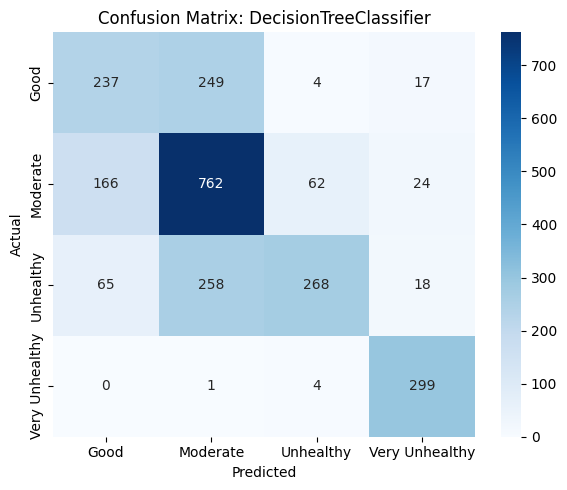

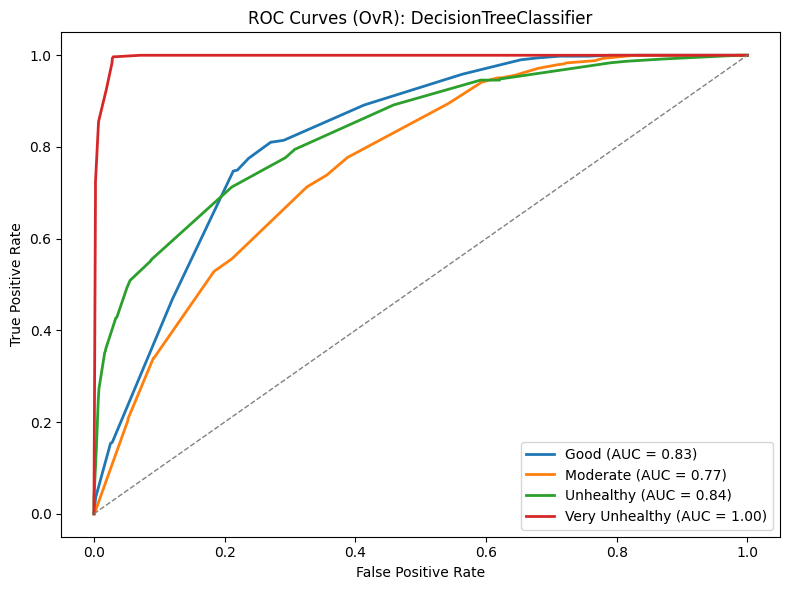

In [39]:
evaluate_ml_model(dt1, X_test, y_test)

## Experiment 2: max_depth=10, min_samples_split=2
This tree has moderate depth, providing a balance between capturing complex feature interactions and avoiding overfitting. This experiment serves as a baseline to compare against shallower and deeper trees.


In [40]:
dt2 = DecisionTreeClassifier(max_depth=10, min_samples_split=2, random_state=42)
dt2 = train_ml_model(dt2, X_train, y_train)


Accuracy:  0.7753
Precision: 0.7789
Recall:    0.7753
F1-score:  0.7718
                precision    recall  f1-score   support

          Good       0.74      0.55      0.63       507
      Moderate       0.71      0.84      0.77      1014
     Unhealthy       0.82      0.75      0.78       609
Very Unhealthy       0.99      0.99      0.99       304

      accuracy                           0.78      2434
     macro avg       0.81      0.78      0.79      2434
  weighted avg       0.78      0.78      0.77      2434



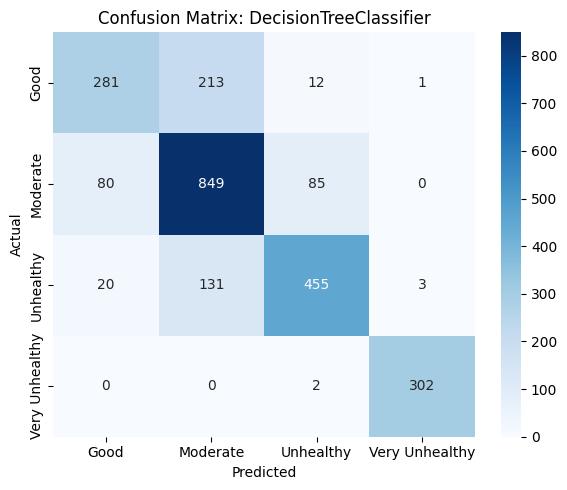

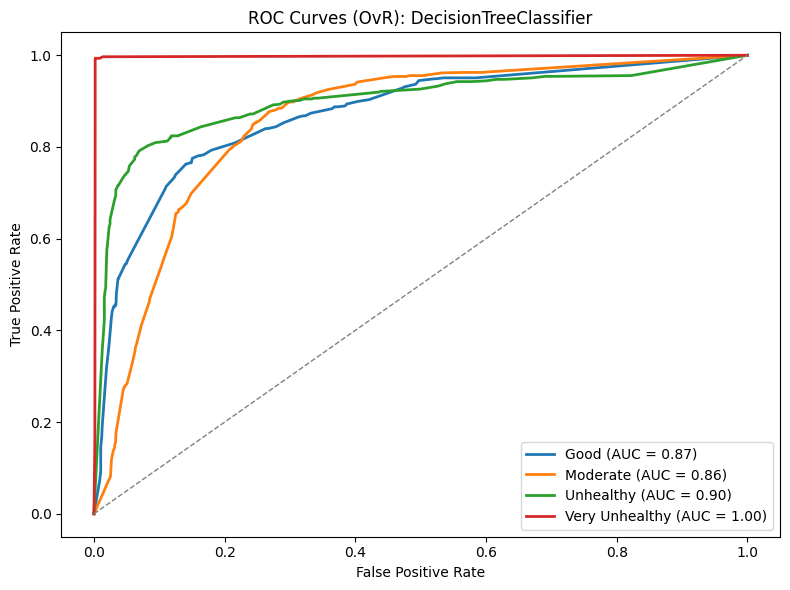

In [41]:
evaluate_ml_model(dt2, X_test, y_test)

## Experiment 3: max_depth=15, min_samples_split=5
A deeper tree with stricter splitting rules is used to capture more detailed patterns in the data. While potentially increasing accuracy, the risk of overfitting also increases. This experiment evaluates the trade-off between complexity and interpretability.

In [42]:
dt3 = DecisionTreeClassifier(max_depth=15, min_samples_split=5, random_state=42)
dt3 = train_ml_model(dt3, X_train, y_train)

Accuracy:  0.7933
Precision: 0.7935
Recall:    0.7933
F1-score:  0.7920
                precision    recall  f1-score   support

          Good       0.69      0.62      0.65       507
      Moderate       0.75      0.82      0.78      1014
     Unhealthy       0.85      0.79      0.82       609
Very Unhealthy       0.99      0.99      0.99       304

      accuracy                           0.79      2434
     macro avg       0.82      0.81      0.81      2434
  weighted avg       0.79      0.79      0.79      2434



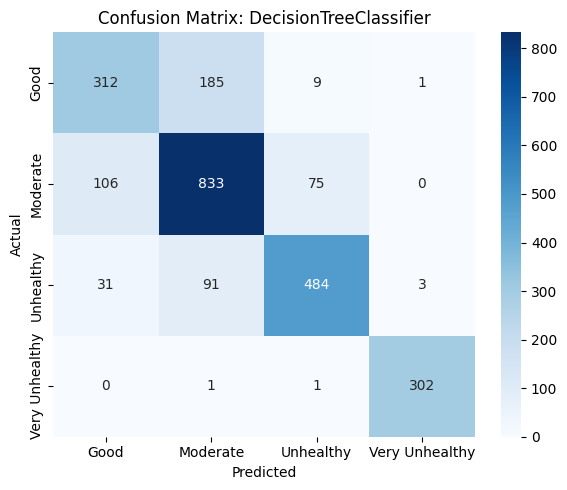

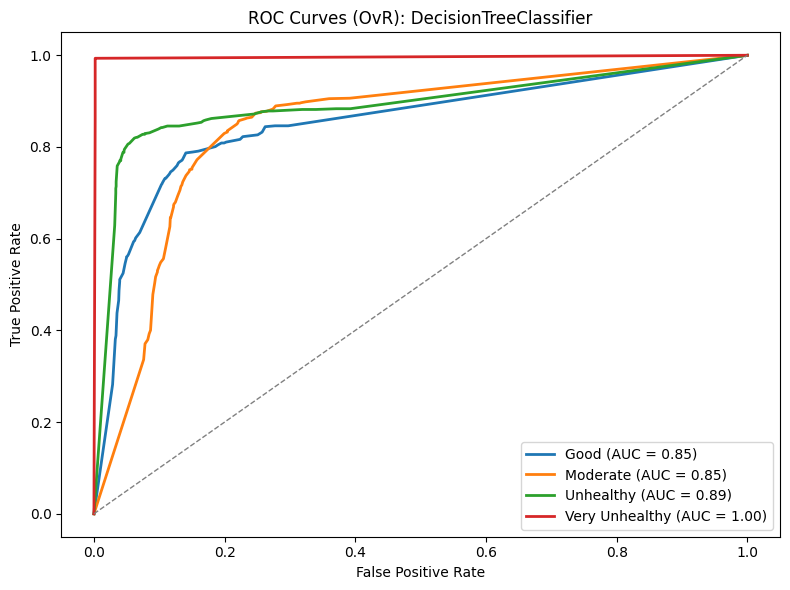

In [43]:
evaluate_ml_model(dt3, X_test, y_test)

## Random Forest Classifier
Random Forest is an ensemble model that combines multiple decision trees to improve generalization and reduce overfitting. It reduces variance by averaging predictions and provides feature importance metrics.


### Experiment 4: n_estimators=200, max_depth=20, min_samples_leaf=1, class_weight= balanced
A moderate-sized forest with medium depth is used to examine accuracy and generalization. The model balances computational cost with performance and is expected to provide stable predictions.

In [44]:
rf1 = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=1, random_state=42, class_weight= 'balanced')
rf1 = train_ml_model(rf1, X_train, y_train)


Accuracy:  0.8164
Precision: 0.8193
Recall:    0.8164
F1-score:  0.8169
                precision    recall  f1-score   support

          Good       0.73      0.74      0.73       507
      Moderate       0.77      0.81      0.79      1014
     Unhealthy       0.90      0.80      0.84       609
Very Unhealthy       0.98      0.99      0.99       304

      accuracy                           0.82      2434
     macro avg       0.84      0.84      0.84      2434
  weighted avg       0.82      0.82      0.82      2434



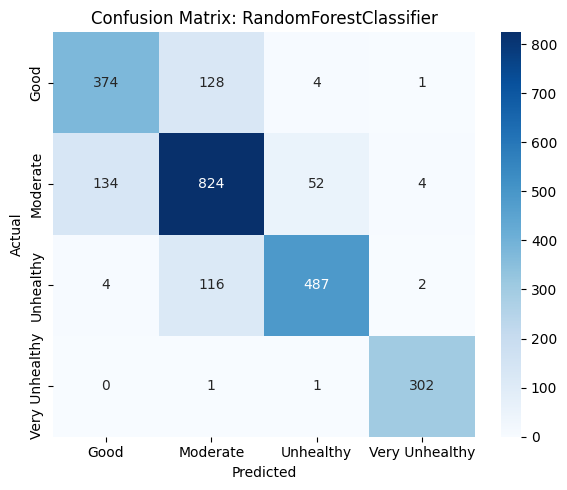

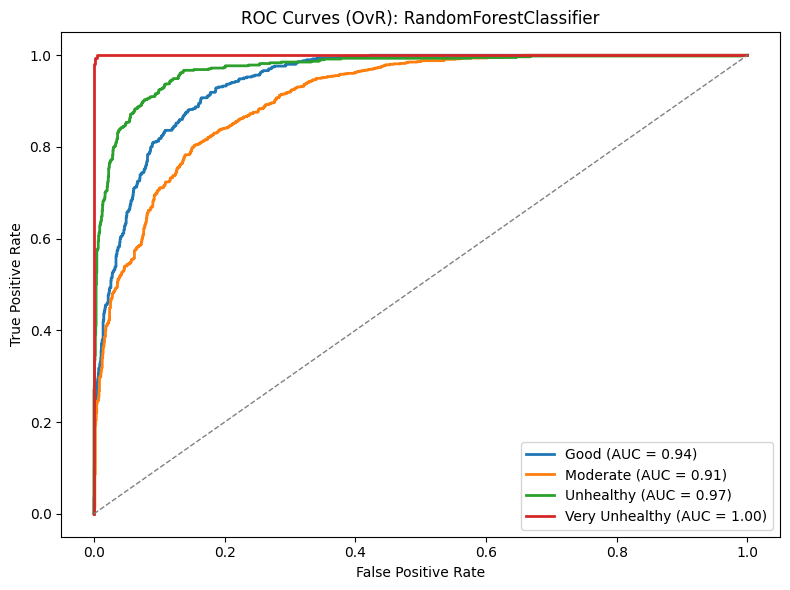

In [45]:
evaluate_ml_model(rf1, X_test, y_test)

### Experiment 5: n_estimators=500, max_depth=30, min_samples_leaf=3
A larger and deeper forest is used to investigate whether increasing the number of trees and depth improves performance. This experiment also highlights the trade-off between computation time and predictive accuracy, as deeper and larger forests require more resources.

In [46]:
rf2 = RandomForestClassifier(n_estimators=500, max_depth=30, min_samples_leaf=3, random_state=42)
rf2 = train_ml_model(rf2, X_train, y_train)


Accuracy:  0.8106
Precision: 0.8139
Recall:    0.8106
F1-score:  0.8103
                precision    recall  f1-score   support

          Good       0.74      0.67      0.71       507
      Moderate       0.75      0.83      0.79      1014
     Unhealthy       0.89      0.79      0.84       609
Very Unhealthy       0.98      0.99      0.99       304

      accuracy                           0.81      2434
     macro avg       0.84      0.82      0.83      2434
  weighted avg       0.81      0.81      0.81      2434



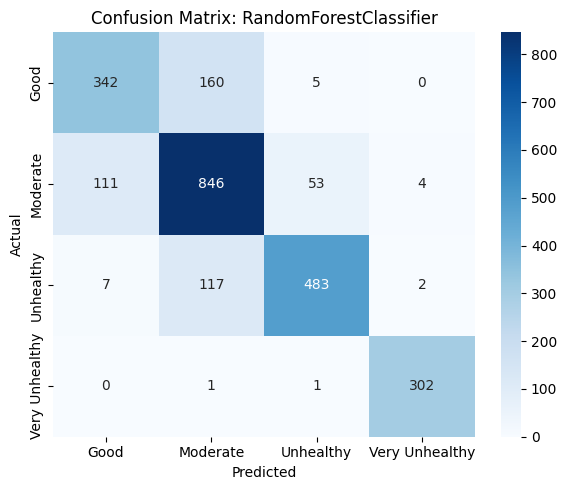

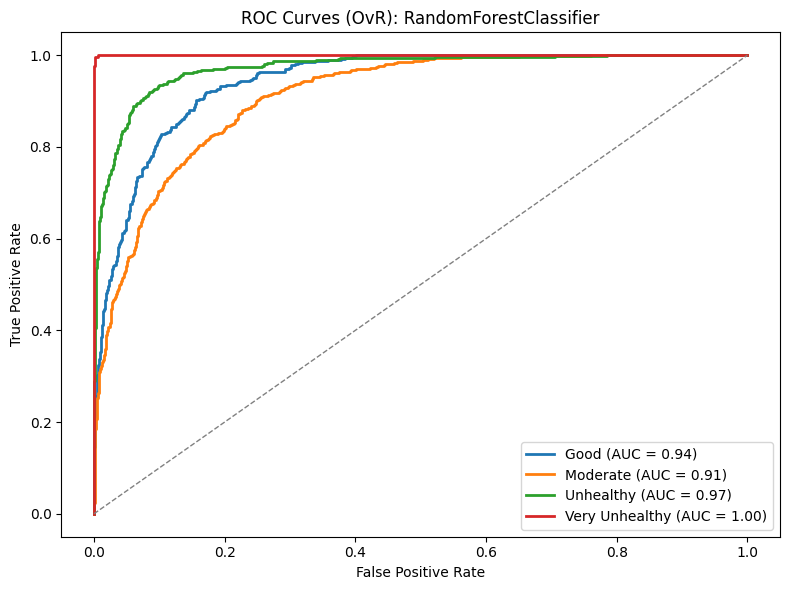

In [47]:
evaluate_ml_model(rf2, X_test, y_test)

# Deep Learning Experiments
Deep learning models are used to capture complex, non-linear patterns in the data that classical ML models may miss. Experiments involve fully connected neural networks with and without dropout, as well as Functional API models with separate subnetworks for heterogeneous features.


In [48]:
y_train_dl = to_categorical(y_train)
y_test_dl = to_categorical(y_test)


In [49]:
classes = np.unique(y_train)
class_weights_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {i: w for i, w in zip(classes, class_weights_values)}

## Feedforward Neural Network (FNN) with Dropout
Feedforward networks are fully connected layers that learn complex feature interactions. Dropout layers are added to reduce overfitting by randomly deactivating neurons during training.

### Experiment 6: 2 hidden layers, 64 neurons, Dropout=0.2, lr=0.001, optimizer=Adam, Batch size =32
This baseline FNN evaluates the network's ability to capture non-linear relationships while maintaining generalization. Dropout prevents overfitting, and the learning rate is set for stable convergence.


In [50]:
fnn6 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train_dl.shape[1], activation='softmax')
])
fnn6.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\fadhl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
history = train_dl_model(
    fnn6, X_train, y_train_dl, 
    X_test, y_test_dl, 
    epochs=100, 
    batch_size=32,
    patience=10  # early stopping patience
)

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2707 - loss: 82.4099 - val_accuracy: 0.4166 - val_loss: 1.5312
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3832 - loss: 2.1998 - val_accuracy: 0.4166 - val_loss: 1.4334
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4038 - loss: 1.5789 - val_accuracy: 0.4166 - val_loss: 1.3865
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4072 - loss: 1.4831 - val_accuracy: 0.4166 - val_loss: 1.3623
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4095 - loss: 1.4063 - val_accuracy: 0.4166 - val_loss: 1.3477
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4098 - loss: 1.3729 - val_accuracy: 0.4166 - val_loss: 1.3380
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4108 - loss: 1.3614 - val_accuracy: 0.4166 - val_loss: 1.3309
Epoch 8/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4089 - loss: 1.3543 - val_acc

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy:  0.4166
Precision: 0.1736
Recall:    0.4166
F1-score:  0.2450
                precision    recall  f1-score   support

          Good       0.00      0.00      0.00       507
      Moderate       0.42      1.00      0.59      1014
     Unhealthy       0.00      0.00      0.00       609
Very Unhealthy       0.00      0.00      0.00       304

      accuracy                           0.42      2434
     macro avg       0.10      0.25      0.15      2434
  weighted avg       0.17      0.42      0.25      2434



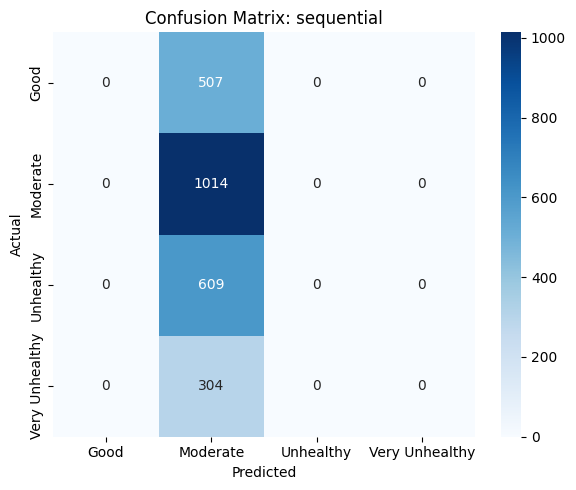

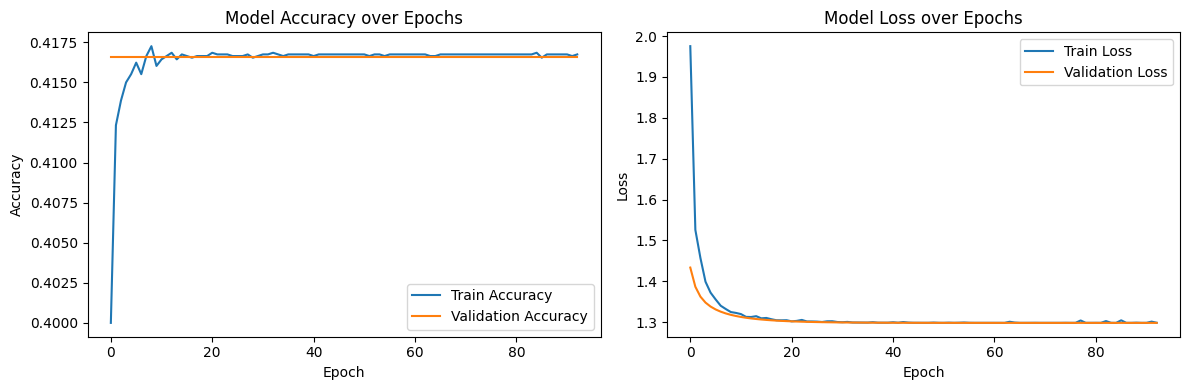

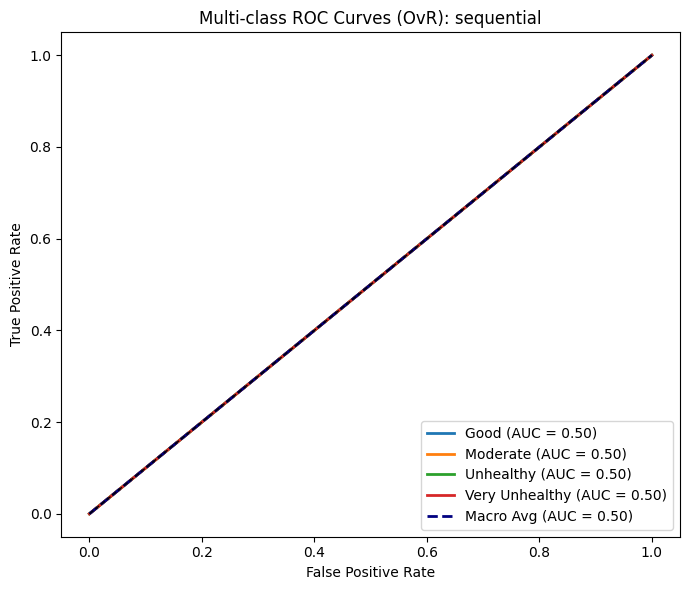

In [52]:
evaluate_dl_model(fnn6, X_test, y_test_dl, history=history)

### Experiment 7: 2 hidden layers, 32 neurons, Dropout=0.2, lr=0.0005, optimizer=RMSprop, Batch size =16
This experiment implements fully connected neural network with two hidden layers of 32 neurons each. Dropout of 0.2 is used to reduce overfitting, while a lower learning rate (0.0005) with the RMSprop optimizer ensures stable convergence. A smaller batch size of 16 is applied to allow finer updates to the weights, making the network sensitive to subtle patterns in the data.

In [53]:
fnn7 = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train_dl.shape[1], activation='softmax')
])

fnn7.compile(
    optimizer=RMSprop(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


c:\Users\fadhl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
history = train_dl_model(
    fnn7, X_train, y_train_dl, 
    X_test, y_test_dl, 
    epochs=100, 
    batch_size=16, 
    patience=10  # early stopping patience
)

Epoch 1/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3037 - loss: 89.7216 - val_accuracy: 0.2391 - val_loss: 1.4542
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3282 - loss: 2.3786 - val_accuracy: 0.4906 - val_loss: 1.1435
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4537 - loss: 1.1960 - val_accuracy: 0.5333 - val_loss: 1.0757
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4941 - loss: 1.1185 - val_accuracy: 0.5222 - val_loss: 1.0453
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5001 - loss: 1.0873 - val_accuracy: 0.5538 - val_loss: 1.0130
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5130 - loss: 1.0594 - val_accuracy: 0.5226 - val_loss: 1.0437
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5261 - loss: 1.0453 - val_accuracy: 0.5567 - val_loss: 0.9924
Epoch 8/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5317 - loss: 1.0322 - val_acc

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy:  0.6389
Precision: 0.6690
Recall:    0.6389
F1-score:  0.6179
                precision    recall  f1-score   support

          Good       0.64      0.36      0.46       507
      Moderate       0.58      0.83      0.68      1014
     Unhealthy       0.82      0.41      0.55       609
Very Unhealthy       0.72      0.92      0.81       304

      accuracy                           0.64      2434
     macro avg       0.69      0.63      0.62      2434
  weighted avg       0.67      0.64      0.62      2434



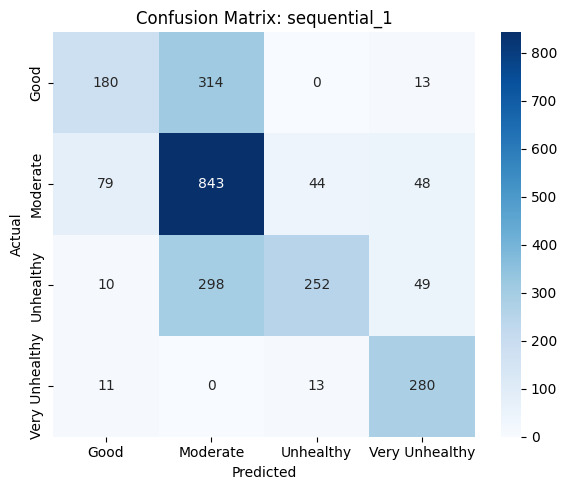

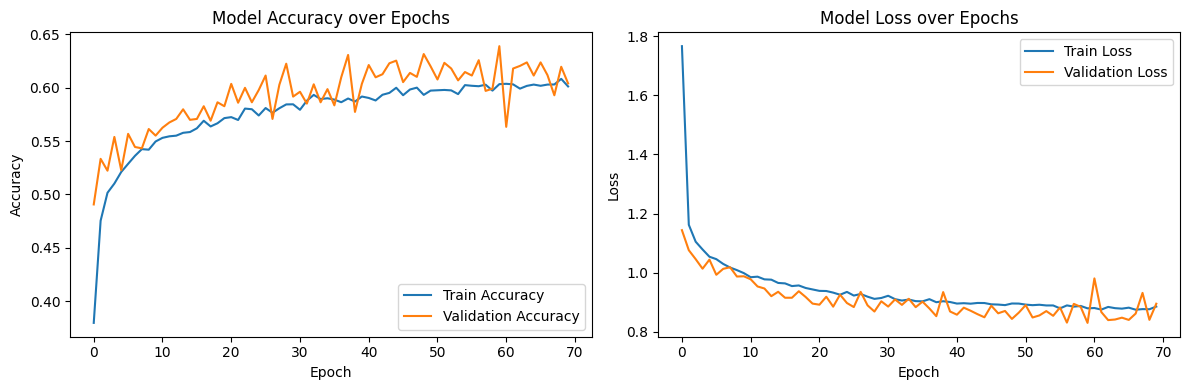

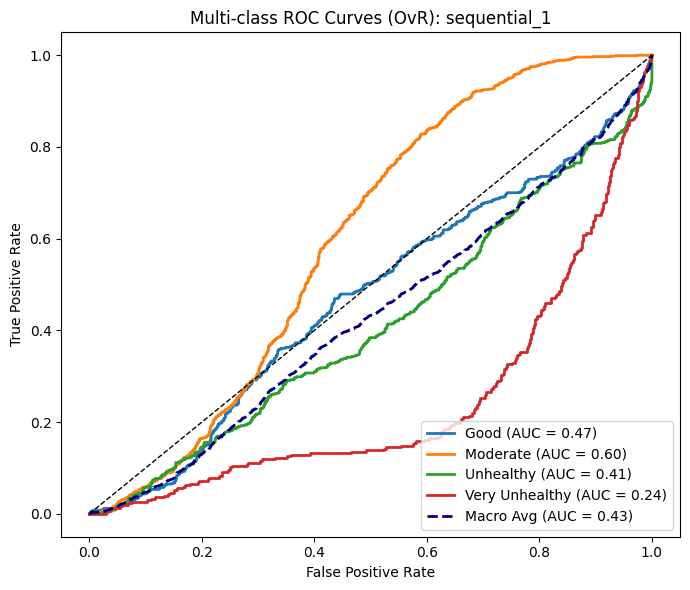

In [55]:
evaluate_dl_model(fnn7, X_test, y_test, history=history)

## Functional API Neural Network
The Functional API allows building separate subnetworks for different feature groups (e.g., meteorological vs satellite features), which are merged for final classification. This design captures feature-specific interactions and heterogeneous data patterns.



### Experiment 8: 2 subnetworks, 64 neurons/layer, Dropout=0.2, lr=0.001, optimizer=Adam, all features
This model tests whether separate subnetworks improve performance compared to a single network. Dropout and learning rate are set for stability and generalization.



In [56]:
input_met = Input(shape=(len(met_features),))
x_met = Dense(64, activation='relu')(input_met)
x_met = Dropout(0.2)(x_met)

input_sat = Input(shape=(len(sat_features),))
x_sat = Dense(64, activation='relu')(input_sat)
x_sat = Dropout(0.2)(x_sat)

merged = Concatenate()([x_met, x_sat])
output = Dense(y_train_dl.shape[1], activation='softmax')(merged)

func_model8 = Model(inputs=[input_met, input_sat], outputs=output)
func_model8.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [57]:
history = train_dl_model(func_model8,
                         [X_train[met_features], X_train[sat_features]], y_train_dl,
                         [X_test[met_features], X_test[sat_features]], y_test_dl,
                         epochs=100)




Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3039 - loss: 79.6537 - val_accuracy: 0.4979 - val_loss: 5.4375
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3846 - loss: 12.0828 - val_accuracy: 0.4971 - val_loss: 1.7937
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4996 - loss: 1.8986 - val_accuracy: 0.5497 - val_loss: 1.0728
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5309 - loss: 1.1888 - val_accuracy: 0.5842 - val_loss: 0.9163
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5372 - loss: 1.0429 - val_accuracy: 0.6130 - val_loss: 0.8748
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5522 - loss: 0.9952 - val_accuracy: 0.6220 - val_loss: 0.8440
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5691 - loss: 0.9409 - val_accuracy: 0.6241 - val_loss: 0.8355
Epoch 8/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5730 - loss: 0.9308 - val_ac

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy:  0.7182
Precision: 0.7232
Recall:    0.7182
F1-score:  0.7151
                precision    recall  f1-score   support

          Good       0.65      0.54      0.59       507
      Moderate       0.65      0.77      0.70      1014
     Unhealthy       0.81      0.64      0.71       609
Very Unhealthy       0.92      1.00      0.96       304

      accuracy                           0.72      2434
     macro avg       0.76      0.74      0.74      2434
  weighted avg       0.72      0.72      0.72      2434



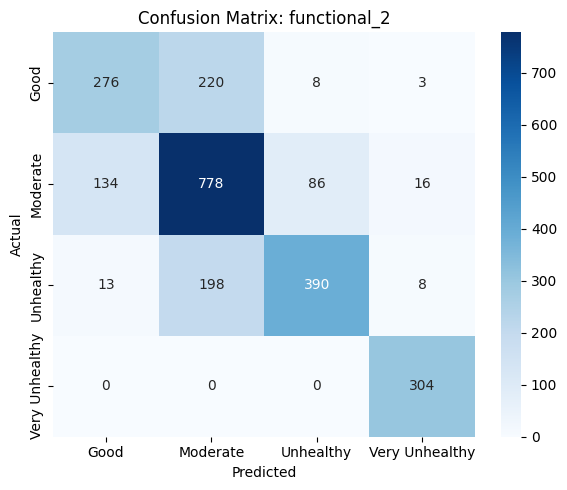

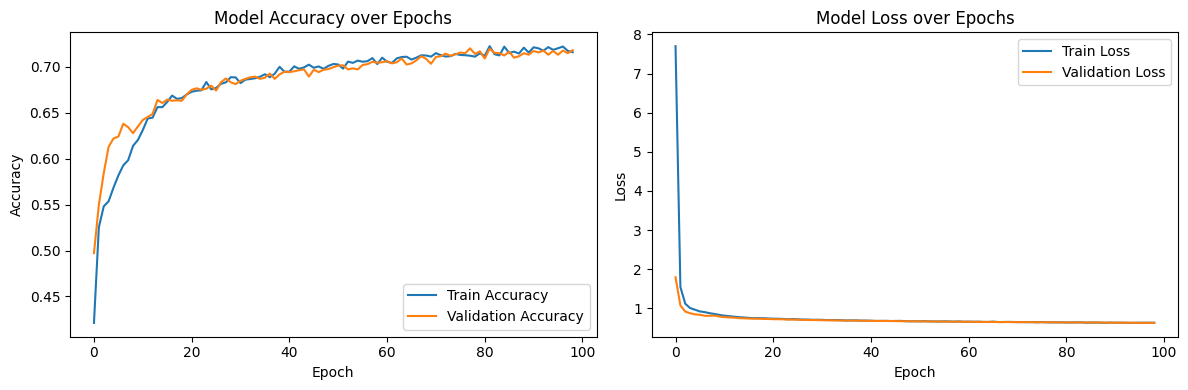

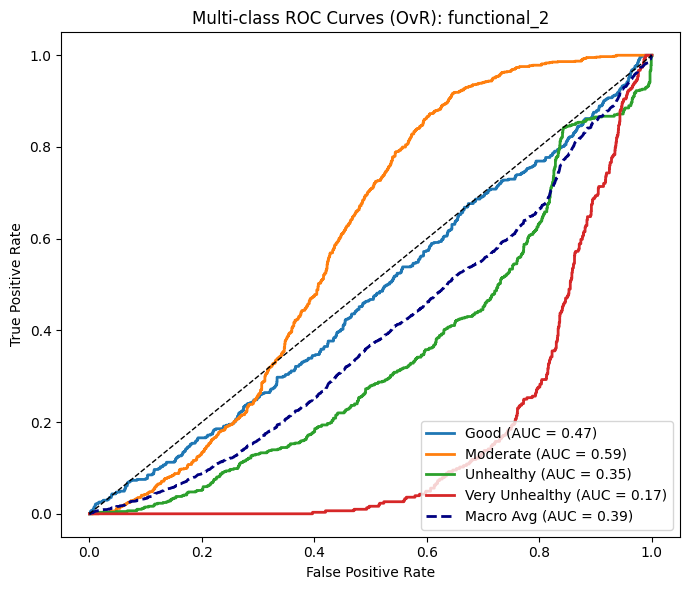

In [58]:
evaluate_dl_model(func_model8,
                  [X_test[met_features], X_test[sat_features]], y_test_dl,
                  history=history)

### Experiment 9: 3 subnetworks, 128 neurons/layer, Dropout=0.3, lr=0.005, optimizer=RMSprop, remove lower-importance features
This deeper and wider network explores the effect of increasing network complexity, higher dropout, and different optimizer. Features with low importance (from Random Forest analysis) are removed to assess the impact of feature selection on accuracy, training time, and overfitting.


In [59]:
# Define functional API model
# Subnetwork 1
input1 = Input(shape=(len(subnet1),))
x1 = Dense(128, activation='relu')(input1)
x1 = Dropout(0.3)(x1)

# Subnetwork 2
input2 = Input(shape=(len(subnet2),))
x2 = Dense(128, activation='relu')(input2)
x2 = Dropout(0.3)(x2)

# Subnetwork 3
input3 = Input(shape=(len(subnet3),))
x3 = Dense(128, activation='relu')(input3)
x3 = Dropout(0.3)(x3)

In [60]:
# Merge subnetworks
merged = Concatenate()([x1, x2, x3])
output = Dense(y_train_dl.shape[1], activation='softmax')(merged)


In [61]:
func_model9 = Model(inputs=[input1, input2, input3], outputs=output)
func_model9.compile(optimizer=RMSprop(learning_rate=0.005), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])


In [62]:
history = train_dl_model(
    func_model9,
    [X_train[subnet1], X_train[subnet2], X_train[subnet3]],
    y_train_dl,
    [X_test[subnet1], X_test[subnet2], X_test[subnet3]],
    y_test_dl,
    epochs=100
)

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5240 - loss: 1.1423 - val_accuracy: 0.5563 - val_loss: 0.9283
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6182 - loss: 0.8462 - val_accuracy: 0.5826 - val_loss: 0.8743
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6349 - loss: 0.8072 - val_accuracy: 0.6039 - val_loss: 0.8503
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6491 - loss: 0.7945 - val_accuracy: 0.6056 - val_loss: 0.8545
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6571 - loss: 0.7800 - val_accuracy: 0.6389 - val_loss: 0.7846
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6587 - loss: 0.7743 - val_accuracy: 0.6393 - val_loss: 0.7994
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6699 - loss: 0.7559 - val_accuracy: 0.6422 - val_loss: 0.7776
Epoch 8/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6686 - loss: 0.7514 - val_accu

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy:  0.7321
Precision: 0.7313
Recall:    0.7321
F1-score:  0.7314
                precision    recall  f1-score   support

          Good       0.65      0.64      0.64       507
      Moderate       0.70      0.72      0.71      1014
     Unhealthy       0.76      0.71      0.73       609
Very Unhealthy       0.91      0.96      0.93       304

      accuracy                           0.73      2434
     macro avg       0.75      0.76      0.76      2434
  weighted avg       0.73      0.73      0.73      2434



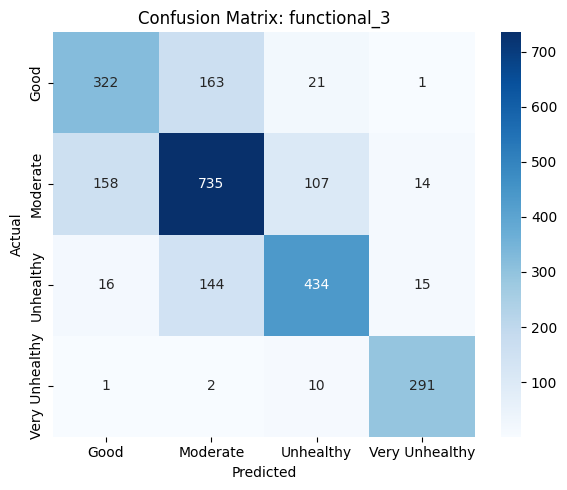

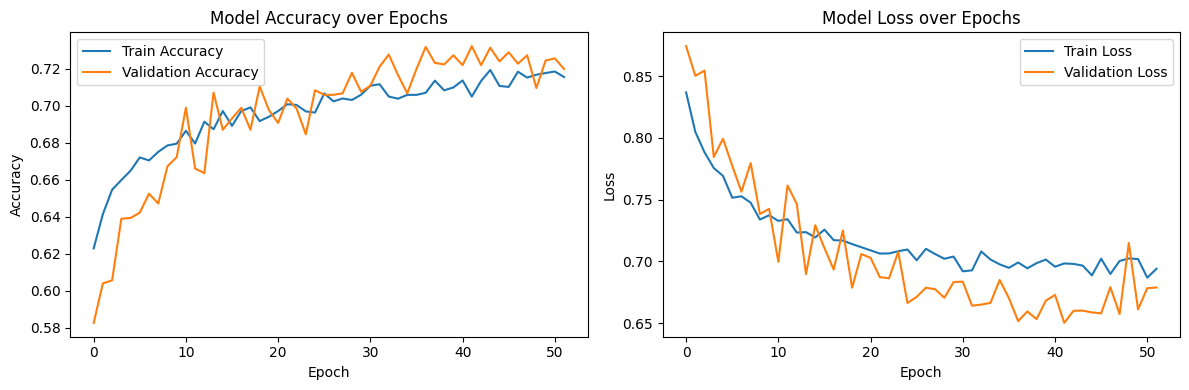

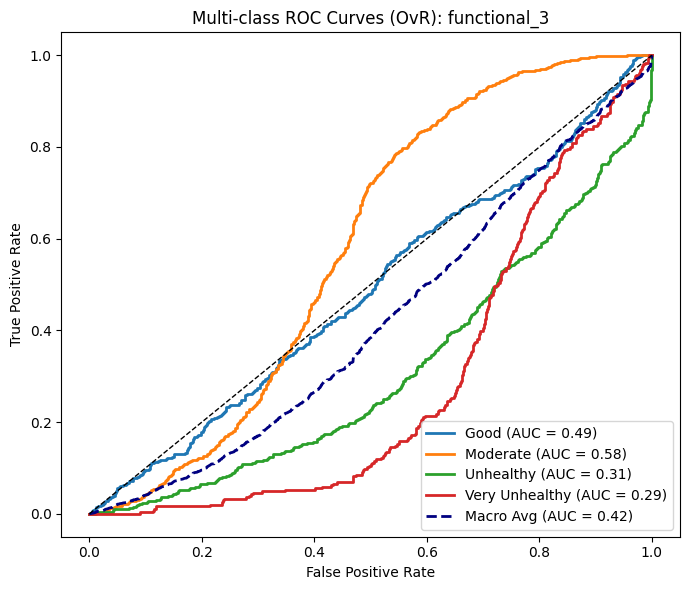

In [63]:
evaluate_dl_model(
    func_model9,
    [X_test[subnet1], X_test[subnet2], X_test[subnet3]],
    y_test_dl,
    history=history
)